In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
import itertools
from itertools import product
import warnings
from sklearn.model_selection import TimeSeriesSplit
warnings.filterwarnings("ignore") 

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [26]:
data = pd.read_csv('../data/regional_univariate_data.csv')


enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

In [27]:
# Split the datasets

def prepare_and_split_data(data, test_size = 0.15):
    data = data.sort_values('date')
    testsize = int(len(data) * (1-test_size))
    train, test = data[0:testsize], data[testsize:]
    return train, test


def prepare_data(data):
    data = data[['date', 'new_confirmed']].copy() 
    data.set_index('date', inplace=True)
    data.sort_index(inplace=True)
    data.index = pd.to_datetime(data.index)
    return data


datasets = [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]
processed_datasets = [prepare_data(df) for df in datasets]
enc, esc, midatl, mount, ne, pac, satl, wnc, wsc = processed_datasets

enc_train, enc_test = prepare_and_split_data(enc)
esc_train, esc_test = prepare_and_split_data(esc)
midatl_train, midatl_test = prepare_and_split_data(midatl)
mount_train, mount_test = prepare_and_split_data(mount)
ne_train, ne_test = prepare_and_split_data(ne)
pac_train, pac_test = prepare_and_split_data(pac)
satl_train, satl_test = prepare_and_split_data(satl)
wnc_train, wnc_test = prepare_and_split_data(wnc)
wsc_train, wsc_test = prepare_and_split_data(wsc)
print("Length enc train: ", len(enc_train))
print("Length enc test: ", len(enc_test))
enc_test

Length enc train:  822
Length enc test:  146


,new_confirmed
date,
2022-04-23,0.0
2022-04-24,0.0
2022-04-25,13502.0
2022-04-26,3675.0
2022-04-27,15212.0
...,...
2022-09-11,0.0
2022-09-12,11585.0
2022-09-13,13869.0


In [4]:
def arima_search(train_orig, test_orig, p_range = range(0,8), d_range = range(0,1), q_range = range(0, 8), log_transform = 'False'):
    scores = []
    params = list(itertools.product(p_range, d_range, q_range))
    tscv = TimeSeriesSplit()
    train = train_orig.copy()
    test = test_orig.copy()

    counter = 0
    lenpar = len(params)
    for combination in params:
        all_scores = []
        for train_idx, test_idx in tscv.split(train['new_confirmed']):
            tscv_train, tscv_test = train['new_confirmed'].iloc[train_idx], train['new_confirmed'].iloc[test_idx]
            model = ARIMA(tscv_train, order=combination)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(tscv_test))
            mase = mean_absolute_scaled_error(tscv_test, forecast, y_train=tscv_train)
            all_scores.append(mase)

        
        mase = np.mean(all_scores)
        # print('combo: ', combination)
        # print("total mase: ", mase)
        counter += 1
        print('done: ', counter, ' out of ', lenpar)
        # if round(counter/lenpar, 1) in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        #     print('done: ', round(counter/lenpar, 1))

        scores.append((combination, mase))

    best_params, best_score = min(scores, key=lambda x: x[1])

    best_model = ARIMA(train['new_confirmed'], order=best_params)
    best_model_fit = best_model.fit()
    
    print(best_model_fit.summary())

    forecast = best_model_fit.forecast(steps=len(test))
    test_data = test['new_confirmed']

    mase = mean_absolute_scaled_error(test_data, forecast, y_train = train['new_confirmed'])

    print(f"Best Model: ARIMA{best_params} with MASE {mase}")
    mae = mean_absolute_error(test['new_confirmed'], forecast)
    print(f"Best MAE {mae}")
    rmse = np.sqrt(mean_squared_error(test['new_confirmed'], forecast))
    print(f"Best RMSE {rmse}")



    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data, label='New Cases')
    plt.plot(test_data.index, forecast, label='Predicted New Cases', alpha=0.7)
    plt.title('Actual and Predicted Daily New Cases')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend()
    plt.show()

    return best_params, mase


In [37]:
def new_arima_search(train, test, p = range(8), q = range(22), d = [0], region = "East North Central"):
    orders = list(product(p, d, q))
    scores = []

    counter = 0
    lenorder = len(orders)
    for order in orders:
        model = ARIMA(train['new_confirmed'], order = order)
        fitted_model = model.fit()
        scores.append((order, fitted_model.aic))
        counter += 1
        if round(counter/lenorder) in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            print('done: ', round(counter/lenorder, 2))

    scores = sorted(scores, key = lambda x: x[1])

    # scores_df = pd.DataFrame(scores, columns=['Order', 'AIC'])
    #print(scores_df)

    best_order = scores[0][0]

    best_model = ARIMA(train['new_confirmed'], order=best_order)
    best_model_fit = best_model.fit()

    print(best_model_fit.summary())

    start = len(train)
    end = start + len(test) - 1
    test_predictions = best_model_fit.predict(start=start, end=end, typ='levels')

    plt.figure(figsize=(10, 6))
    plt.plot(np.array(test['new_confirmed'].index), np.array(test['new_confirmed']), label='Test')
    plt.plot(np.array(test['new_confirmed'].index), np.array(test_predictions), label='ARIMA Test Predictions')
    plt.title("New Cases and Predictions for the " + str(region) + " Region")
    plt.legend()
    plt.show()

    mase = mean_absolute_scaled_error(np.array(test['new_confirmed']), np.array(test_predictions), y_train = np.array(train['new_confirmed']))
    rmse = np.sqrt(mean_squared_error(np.array(test['new_confirmed']),np.array(test_predictions)))
    mae =  mean_absolute_error(np.array(test['new_confirmed']),np.array(test_predictions))
    print('MASE: ', mase)
    print("RMSE: ", rmse)
    print("MAE: ", mae)

### Below is old code using test mase and log transforming, don't run

In [22]:
# def arima_search(train, test, p_range = range(0,8), d_range = range(0,1), q_range = range(0, 8), log_transform = 'False'):
#     scores = []
#     params = list(itertools.product(p_range, d_range, q_range))
    
#     for combination in params:
#         model = ARIMA(train['new_confirmed'], order = combination)
#         model = model.fit()
#         forecast = model.forecast(steps=len(test))
#         mase_score = mean_absolute_scaled_error(test['new_confirmed'], forecast, y_train=train['new_confirmed'])
#         scores.append((combination, mase_score))

#     best_params, best_mase = min(scores, key=lambda x: x[1])

#     # combined_data = pd.concat([train['new_confirmed'], test['new_confirmed']])

#     best_model = ARIMA(train['new_confirmed'], order=best_params)
#     best_model_fit = best_model.fit()
    
#     print(best_model_fit.summary())

#     forecast = best_model_fit.forecast(steps=len(test))
#     test_data = test['new_confirmed']

#     print(f"Best Model: ARIMA{best_params} with MASE {best_mase}")
#     mae = mean_absolute_error(test['new_confirmed'], forecast)
#     print(f"Best MAE {mae}")
#     rmse = np.sqrt(mean_squared_error(test['new_confirmed'], forecast))
#     print(f"Best RMSE {rmse}")



#     plt.figure(figsize=(10, 6))
#     plt.plot(test_data.index, test_data, label='New Cases')
#     plt.plot(test_data.index, forecast, label='Predicted New Cases', alpha=0.7)
#     plt.title('Actual and Predicted Daily New Cases')
#     plt.xlabel('Date')
#     plt.ylabel('New Cases')
#     plt.legend()
#     plt.show()

#     return best_params, best_mase


In [22]:
# def log_transform(x):
#     return np.log(x) if x > 0 else 0


# East North Central

done:  1  out of  1
                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 17)   Log Likelihood               -8616.237
Date:                Mon, 11 Mar 2024   AIC                          17284.474
Time:                        21:33:28   BIC                          17406.980
Sample:                             0   HQIC                         17331.475
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.401e+04   1.06e+04      1.326      0.185   -6699.191    3.47e+04
ar.L1         -0.0679      0.026     -2.609      0.009      -0.119      -0.017
ar.L2         -0.0402      0.020

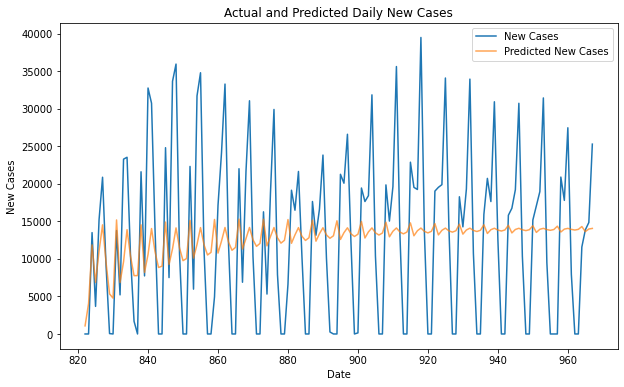

In [6]:
# enc_params, enc_mase = arima_search(enc_train, enc_test, p_range = [0, 1, 2 ,7], q_range = [0, 7, 8, 9, 10, 11, 14, 19, 21, 28])
enc_params, enc_mase = arima_search(enc_train, enc_test, p_range = [7], q_range = [17])

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 19)   Log Likelihood               -8616.712
Date:                Mon, 11 Mar 2024   AIC                          17289.424
Time:                        22:58:07   BIC                          17421.353
Sample:                    01-22-2020   HQIC                         17340.040
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.401e+04   1.14e+04      1.233      0.218   -8264.291    3.63e+04
ar.L1         -0.0664      0.027     -2.439      0.015      -0.120      -0.013
ar.L2         -0.0379      0.022     -1.695      0.0

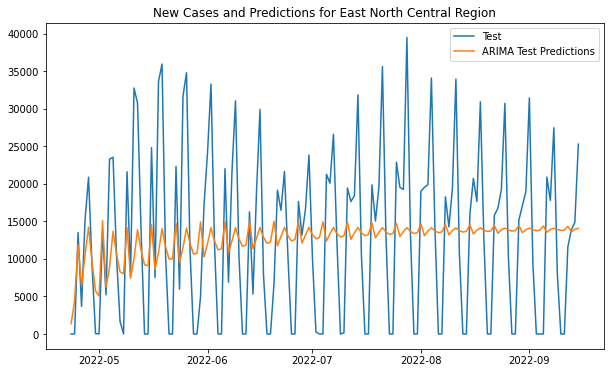

MASE:  1.0700311644099318
RMSE:  10382.707211331914
MAE:  8486.056143458261


In [33]:
new_arima_search(enc_train, enc_test, p = [0, 1, 2 ,7], q = [0, 7, 8, 9, 10, 11, 14, 19, 21, 28])

done:  1.0
                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 17)   Log Likelihood               -8616.237
Date:                Mon, 11 Mar 2024   AIC                          17284.474
Time:                        21:52:20   BIC                          17406.980
Sample:                             0   HQIC                         17331.475
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.401e+04   1.06e+04      1.326      0.185   -6699.191    3.47e+04
ar.L1         -0.0679      0.026     -2.609      0.009      -0.119      -0.017
ar.L2         -0.0402      0.020     -1.9

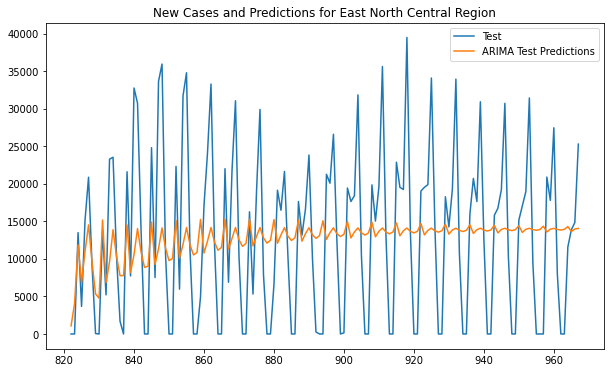

MASE:  1.06531250803486
RMSE:  10355.960099822192
MAE:  8448.634071791192


In [9]:
new_arima_search(enc_train, enc_test, p = [7], q = [17])

# East South Central

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 21)   Log Likelihood               -8187.180
Date:                Mon, 11 Mar 2024   AIC                          16434.361
Time:                        22:07:30   BIC                          16575.713
Sample:                             0   HQIC                         16488.592
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6590.0073   6179.531      1.066      0.286   -5521.652    1.87e+04
ar.L1          0.3715      0.224      1.656      0.098      -0.068       0.811
ar.L2         -0.1206      0.264     -0.456      0.6

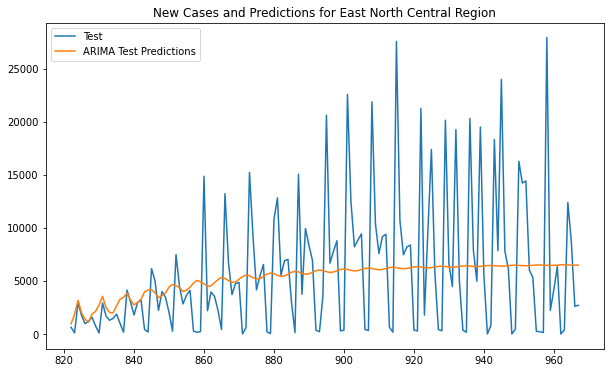

MASE:  1.2850896845332782
RMSE:  6065.111104527776
MAE:  4258.361460104559


In [13]:
new_arima_search(esc_train, esc_test, p = [0, 1, 2, 3,7], q = [0, 1, 2, 3, 4, 5, 6, 7, 14, 21])

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 14)   Log Likelihood               -8201.118
Date:                Fri, 01 Mar 2024   AIC                          16448.236
Time:                        23:51:42   BIC                          16556.606
Sample:                             0   HQIC                         16489.813
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6590.0073   6850.014      0.962      0.336   -6835.773       2e+04
ar.L1          0.1217      0.149      0.820      0.412      -0.169       0.413
ar.L2          0.1334      0.138      0.965      0.3

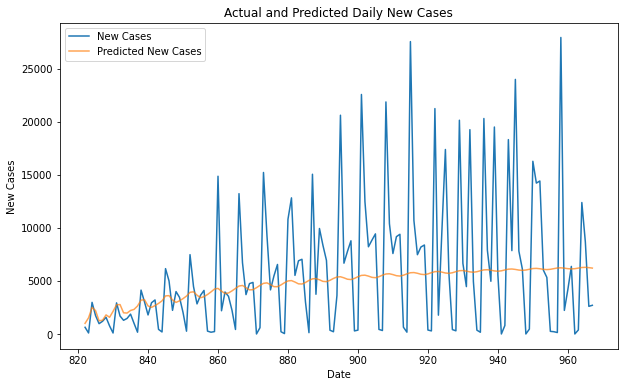

In [26]:
# esc_params, esc_mase = arima_search(esc_train, esc_test, p_range = [0, 1, 2, 3,7], q_range = [0, 1, 2, 3, 4, 5, 6, 7, 14, 21])

# Mid-Atlantic

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(9, 0, 10)   Log Likelihood               -8022.789
Date:                Mon, 11 Mar 2024   AIC                          16087.577
Time:                        23:04:32   BIC                          16186.524
Sample:                    01-22-2020   HQIC                         16125.540
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.232e+04   8087.786      1.523      0.128   -3536.365    2.82e+04
ar.L1          0.4956      0.118      4.191      0.000       0.264       0.727
ar.L2         -0.0612      0.157     -0.389      0.6

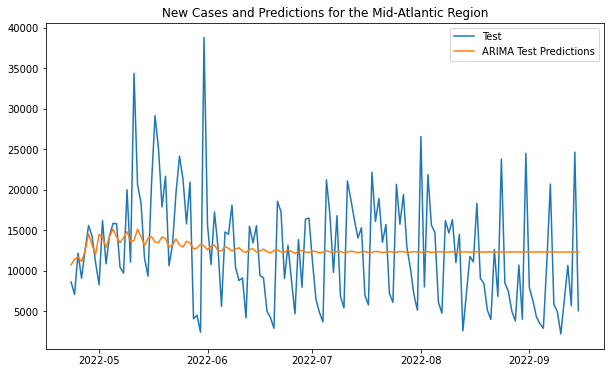

MASE:  2.4876145775882406
RMSE:  6514.229970888893
MAE:  5274.3458707488735


In [39]:
new_arima_search(midatl_train, midatl_test, p = [0, 1, 2, 8, 9], q = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], region = 'Mid-Atlantic')

# Mountain

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 21)   Log Likelihood               -8200.992
Date:                Mon, 11 Mar 2024   AIC                          16461.983
Time:                        22:27:41   BIC                          16603.335
Sample:                             0   HQIC                         16516.215
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7838.9416   5485.062      1.429      0.153   -2911.582    1.86e+04
ar.L1         -0.0881      0.046     -1.916      0.055      -0.178       0.002
ar.L2          0.0261      0.066      0.398      0.6

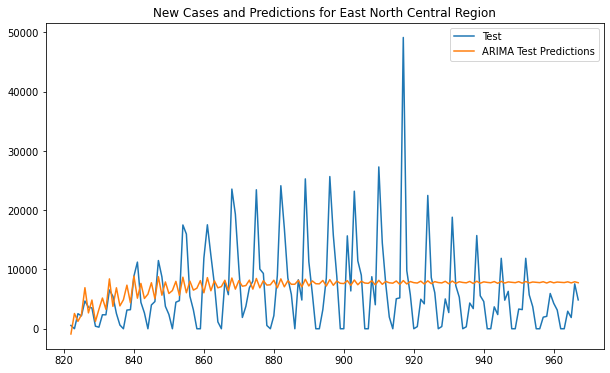

MASE:  1.6302352799707711
RMSE:  7076.94826956247
MAE:  5155.306329842283


In [16]:
new_arima_search(mount_train, mount_test, p = [0, 1, 2, 3, 6, 7, 9, 10, 21], q = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21])

# New England

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:               ARIMA(10, 0, 21)   Log Likelihood               -8023.151
Date:                Mon, 11 Mar 2024   AIC                          16112.302
Time:                        22:29:47   BIC                          16267.789
Sample:                             0   HQIC                         16171.956
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4294.0669   4241.829      1.012      0.311   -4019.765    1.26e+04
ar.L1         -0.1548      2.184     -0.071      0.943      -4.435       4.125
ar.L2         -0.3962      1.137     -0.348      0.7

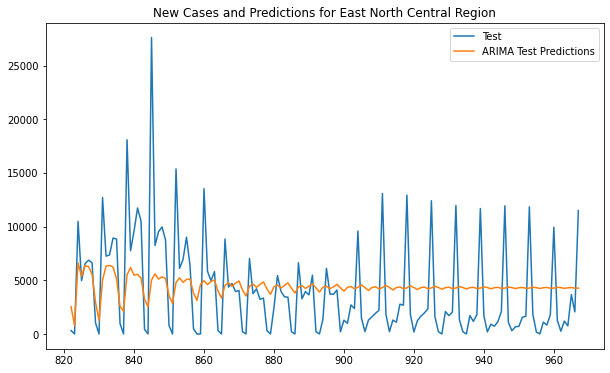

MASE:  1.2915682822792571
RMSE:  4174.952605761619
MAE:  3220.2840310699908


In [17]:
new_arima_search(ne_train, ne_test, p = [0, 1, 3, 6, 7, 10], q = [0, 1, 3, 4, 6, 7, 8, 14, 21])

# Pacific

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:               ARIMA(10, 0, 21)   Log Likelihood               -8714.179
Date:                Mon, 11 Mar 2024   AIC                          17494.359
Time:                        22:33:39   BIC                          17649.846
Sample:                             0   HQIC                         17554.014
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.432e+04   1.32e+04      1.086      0.278   -1.15e+04    4.02e+04
ar.L1         -0.2758      0.139     -1.984      0.047      -0.548      -0.003
ar.L2         -0.0662      0.165     -0.402      0.6

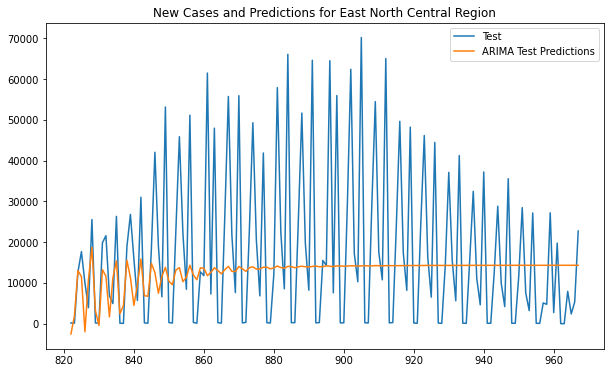

MASE:  2.160038668186483
RMSE:  19390.25615899926
MAE:  14431.41303504238


In [18]:
new_arima_search(pac_train, pac_test, p = [0, 1, 3, 7, 9, 10], q = [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 21])

# South Atlantic

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:               ARIMA(13, 0, 21)   Log Likelihood               -9097.381
Date:                Mon, 11 Mar 2024   AIC                          18266.761
Time:                        22:37:12   BIC                          18436.384
Sample:                             0   HQIC                         18331.839
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.955e+04   1.17e+04      1.677      0.094   -3304.326    4.24e+04
ar.L1          0.4220      0.216      1.952      0.051      -0.002       0.846
ar.L2          0.8981      0.239      3.761      0.0

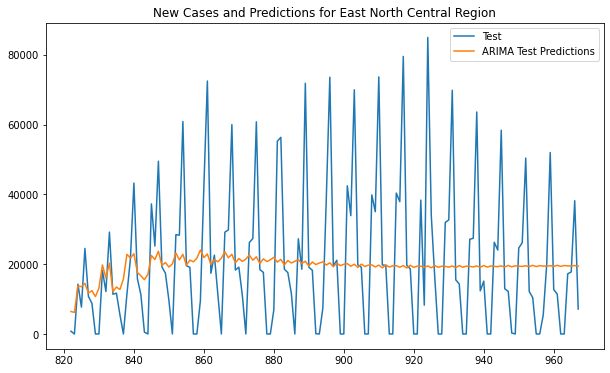

MASE:  1.3850274403948366
RMSE:  19826.83446776848
MAE:  14439.481272297478


In [19]:
new_arima_search(satl_train, satl_test, p = [0, 1, 6, 7, 12, 13], q = [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 21])

# West North Central

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 21)   Log Likelihood               -8118.150
Date:                Mon, 11 Mar 2024   AIC                          16296.299
Time:                        22:44:01   BIC                          16437.651
Sample:                    01-22-2020   HQIC                         16350.531
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6400.6423   4427.813      1.446      0.148   -2277.712    1.51e+04
ar.L1          0.0113      0.046      0.249      0.804      -0.078       0.101
ar.L2         -0.0589      0.053     -1.103      0.2

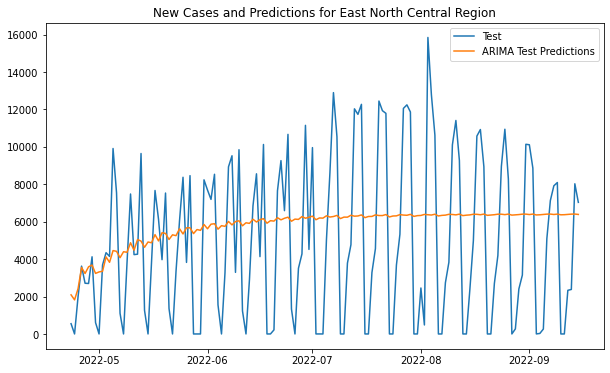

MASE:  1.1816527375920245
RMSE:  4225.231286404806
MAE:  3697.5713265127756


In [30]:
new_arima_search(wnc_train, wnc_test, p = [0, 1, 5, 6, 7], q = [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 21])

# West South Central

                               SARIMAX Results                                
Dep. Variable:          new_confirmed   No. Observations:                  822
Model:                ARIMA(7, 0, 11)   Log Likelihood               -8571.221
Date:                Mon, 11 Mar 2024   AIC                          17182.441
Time:                        22:51:01   BIC                          17276.676
Sample:                    01-22-2020   HQIC                         17218.596
                         - 04-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.197e+04   9371.744      1.277      0.202   -6399.354    3.03e+04
ar.L1          0.1492      0.066      2.274      0.023       0.021       0.278
ar.L2         -0.0005      0.046     -0.010      0.9

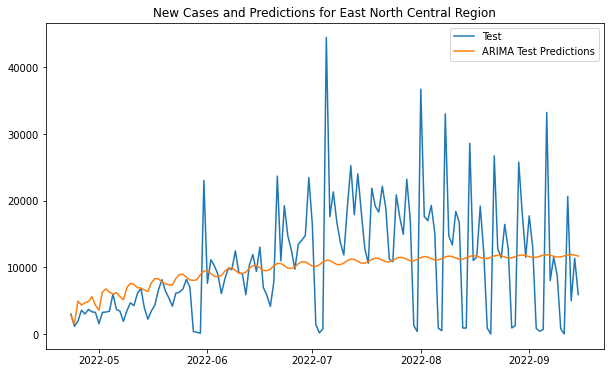

MASE:  1.249938342465197
RMSE:  7706.022818745276
MAE:  5525.261856592889


In [31]:
new_arima_search(wsc_train, wsc_test, p = [0, 1, 2, 7], q = [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 21])